In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import Counter
# svg output in plots
import numpy as np
import tqdm as tqdm
from itertools import chain
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Parameters

In [34]:
# Load data
df = pd.read_pickle(r"../Dataset/dataframe.pkl")
df = df[df["Time"] > 1980]

df_i = df.explode("Simplices").reset_index()
all_authors = df_i["Simplices"].unique()
N_a = len(all_authors)
print("Number of authors:", N_a)

Number of authors: 1153729


In [35]:
### Initial condition age distribution

df_all = pd.read_pickle(r"../Dataset/dataframe.pkl")
df_all = df_all.explode("Simplices").reset_index()
all_ini = df_all.groupby("Simplices").min("Time").reset_index()

all_ini["Age"] = 1980 -  all_ini["Time"]

(array([0.00915608, 0.00863603, 0.00911668, 0.00880938, 0.00929791,
        0.00908516, 0.00941611, 0.00917972, 0.00943975, 0.00945551,
        0.00958946, 0.00898273, 0.00912456, 0.00906941, 0.00929791,
        0.00889605, 0.00920336, 0.009227  , 0.00921912, 0.00862815,
        0.00908516, 0.00895121, 0.00897485, 0.00893545, 0.00886454,
        0.00871482, 0.00921912, 0.00932155, 0.00942399, 0.00917184,
        0.00881726, 0.00925064, 0.00943975, 0.00910092, 0.00928215,
        0.0096131 , 0.00862027, 0.0088409 , 0.00966825, 0.00903789,
        0.00873846, 0.00892757, 0.00916396, 0.00911668, 0.00875422,
        0.00925852, 0.00940823, 0.00929791, 0.00925852, 0.00898273,
        0.00901425, 0.00906941, 0.00874634, 0.0091088 , 0.00865179,
        0.00951854, 0.00930579, 0.00816325, 0.00936095, 0.0088409 ,
        0.00882514, 0.00906941, 0.00914032, 0.00864391, 0.00929791,
        0.00873058, 0.009227  , 0.00864391, 0.00943187, 0.00943187,
        0.00925064, 0.00898273, 0.00848632, 0.00

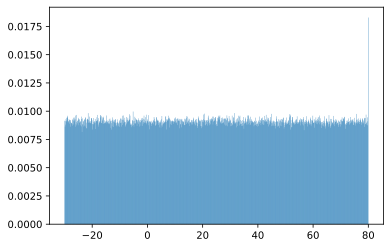

In [36]:
#x = plt.hist(all_ini["Age"], bins=1000, density=True, cumulative=False);

#plt.plot(x[1][1:], x[0], label="Initial condition")

### Academic age distribution

x_life = np.linspace(-30,80,1001)
f_life = x[0]
#plt.plot(x_life,f_life,color="black",linestyle="",marker=".",linewidth=4)

all_ages = np.random.choice(x_life, size=len(all_authors))

plt.hist(all_ages, bins=1000, density=True, cumulative=False, label="Academic age distribution")

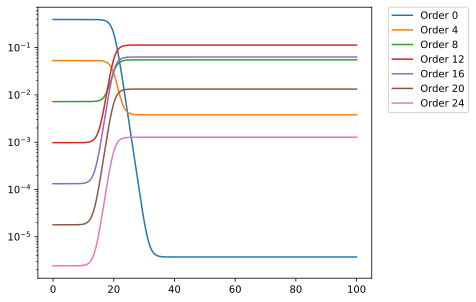

In [37]:
def dist_order(order,age,N):
    alpha = 0.5*(1 + np.tanh(0.5*(age-20)))
    s = 0.5
    Z = np.sum([np.exp(-0.5*o) for o in range(N)])
    e = np.exp(-0.5*order)/Z
    lam = N/2
    Pois = np.exp(-lam)*lam**(order)/np.math.factorial(order)
    return (1-alpha)*e + alpha*Pois

fig, ax = plt.subplots(figsize=(6,5))
v = np.linspace(0,100, 1001)
for order in range(0, 25, 4):
    plt.plot(v, dist_order(order, v, 25), label="Order {}".format(order))
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout
plt.yscale("log")

In [38]:
t0 = 1950
tf = 2021

# Not all authors at the reservoir
N_a = 100
authors = np.array(all_authors[0:N_a])
ages = np.array(all_ages[0:N_a])

# Parameters
N = 25 # Maximum number of orders
r = 5000 #(np.log(10**5 - 10**3))/60 # simplices x year
N_simplices = 1000 # Number of simplices at t0

# Memory matrix
M = np.ones((N_a,N_a))

# If the ages are < 0 or > age_max, we set M = 0
age_max = 80
for i in range(N_a):
    M[i,ages > age_max] = 0
    M[ages > age_max,i] = 0
    M[i,i] = 0

ti = t0

simplices = []
time = []

def p(x, age_max=age_max):
    if x > age_max:
        return 0
    elif x <= 0:
        return 0
    else:
        return 1/(1+x)

def dist_order(order,age,N):
    alpha = 0.5*(1 + np.tanh(0.5*(age-20)))
    s = 0.4
    Z = np.sum([np.exp(-s*o) for o in range(N)])
    e = np.exp(-s*order)/Z
    lam = (N)/3
    Pois = np.exp(-lam)*lam**(order)/np.math.factorial(order)
    return (1-alpha)*e + alpha*Pois

w_t = 0
print("Model starts running")
while ti < tf:
    # Compute total rate:
    W = (r+1)
    
    # Compute next event time
    At = - np.log(np.random.rand())/W
    
    # Time goes on
    ti = ti + At
    w_t = w_t + At
    ages = ages + At
    for i in range(N_a):
        M[i,ages > age_max] = 0
        M[ages > age_max,i] = 0

    # Choose main author according to the age
    possible_authors = np.where(ages > 0)[0]
    i_a = np.random.randint(0,len(possible_authors))
    i_a = possible_authors[i_a]
    while np.random.rand() > p(ages[i_a]):
        i_a = np.random.randint(0,N_a)
    
    # i_a is the main author
    age = ages[i_a]
    o_i = np.random.choice(range(N),p=[dist_order(order,age,N) for order in range(N)]/np.sum([dist_order(order,age,N) for order in range(N)]))
    if o_i > 0:
        possible_collaborators_index = np.where(ages > 0)[0]
        # random choice with preferential attachment from authors to select the collaborators
        if np.sum(M[i_a,:]) > 0:
            i_c = np.random.choice(possible_collaborators_index,size=o_i,replace=False,p=M[i_a,possible_collaborators_index]/np.sum(M[i_a,possible_collaborators_index]))
        else:
            i_c = np.random.choice(possible_collaborators_index,size=o_i,replace=False)
        collaborators = [authors[i] for i in i_c]
        # We update the memory matrix with the new collaboration
        for i in i_c:
            M[i_a,i] = M[i_a,i] + 1
            M[i,i_a] = M[i,i_a] + 1
            for j in i_c:
                M[i,j] = M[i,j] + 1
                M[j,i] = M[j,i] + 1
                M[j,j] = 0
            M[i,i] = 0
        if o_i > 5:
            simplices.append([authors[i_a]] + collaborators)
            time.append(ti)
    if w_t > 1:
        N_simplices = len(simplices)
        print(ti,N_simplices)
        w_t = 0

Model starts running
1951.000162480436 1599
1952.0003625608765 2923
1953.000493818311 4343
1954.000545100912 5658
1955.0012332806373 6962
1956.0015168119892 8179
1957.0015891295627 9530
1958.0017407649825 10973
1959.0019038813484 12486
1960.0025836369057 14161
1961.002609454282 15514
1962.0026567235363 16953
1963.0029184906296 18271
1964.003106313504 19653
1965.0031131017001 21199
1966.0035595531526 22929
1967.0038373442906 24513
1968.0047061890243 25871
1969.0048089924012 27234
1970.0050582306428 28767
1971.00548689973 30367
1972.005576021744 31780
1973.0059757935016 33231
1974.0065169405989 34912
1975.0066244497407 36731
1976.0066545651744 38298
1977.0071643798574 40064
1978.0075424013612 41942
1979.008218563345 43774
1980.0082792790274 45690
1981.0084560731382 47585
1982.0084716586812 49708
1983.008511977964 51944
1984.008815805895 54271
1985.0088938150857 56773
1986.0089493879302 59374
1987.0090133805897 62069
1988.0094195164431 64794
1989.0094941744073 67774
1990.0096526487584 708

In [41]:
df = pd.DataFrame({"Time":time,"Simplices":simplices})

In [42]:
df.to_pickle("./Outcomes/Minimal_model.pkl")